# Deep Deterministic Policy Gradient for Portfolio Management


In [4]:
# code from https://github.com/vermouth1992/drl-portfolio-management

## Experiments with data provided

In [28]:
# for compatible with python 3
from __future__ import print_function
import os
os.environ["KERAS_BACKEND"] = "theano"
import numpy as np
from utils.data import read_stock_history, index_to_date, date_to_index, normalize
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# Seaborn, useful for graphics
import seaborn as sns

# Import Bokeh modules for interactive plotting
import bokeh.io
#import bokeh.mpl
import bokeh.plotting

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
%config InlineBackend.figure_formats = {'png', 'retina'}
matplotlib.rcParams['figure.figsize'] = (10, 6)
plt.rc('legend', fontsize=20)
# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

Loading BokehJS ...

In [30]:
# read the data and choose the target stocks for training a toy example
history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target.h5')
history = history[:, :, :4]
num_training_time = history.shape[1]
num_testing_time = history.shape[1]
window_length = 3

In [32]:
# get target history
target_stocks = ['AAPL', 'COST', 'DISH']
target_history = np.empty(shape=(len(target_stocks), num_training_time, history.shape[2]))
for i, stock in enumerate(target_stocks):
    target_history[i] = history[abbreviation.index(stock), :num_training_time, :]

In [11]:
# collect testing data
testing_stocks = ['CMCSA', 'GOOGL', 'EBAY']
testing_history = np.empty(shape=(len(testing_stocks), num_testing_time, history.shape[2]))
for i, stock in enumerate(target_stocks):
    testing_history[i] = history[abbreviation.index(stock), :num_testing_time, :]

In [33]:
# dataset for 16 stocks by splitting timestamp
history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target.h5')
history = history[:, :, :4]

# 16 stocks are all involved. We choose first 3 years as training data
num_training_time = 1095
target_stocks = abbreviation
target_history = np.empty(shape=(len(target_stocks), num_training_time, history.shape[2]))

for i, stock in enumerate(target_stocks):
    target_history[i] = history[abbreviation.index(stock), :num_training_time, :]

# and last 2 years as testing data.
testing_stocks = abbreviation
testing_history = np.empty(shape=(len(testing_stocks), history.shape[1] - num_training_time, 
                               history.shape[2]))
for i, stock in enumerate(testing_stocks):
    testing_history[i] = history[abbreviation.index(stock), num_training_time:, :]

In [34]:
nb_classes = len(target_stocks) + 1
print(target_history.shape)
print(testing_history.shape)

(16, 1095, 4)
(16, 730, 4)


In [14]:
# visualize 3 stock returns
if False:
    date_list = [index_to_date(i) for i in range(target_history.shape[1])]
    x = range(target_history.shape[1])
    for i in range(len(target_stocks)):
        plt.figure(i)
        plt.plot(x, target_history[i, :, 0])  # return, high, low, close = [0, 1, 2, 3]
        plt.xticks(x[::200], date_list[::200], rotation=30)
        plt.title(target_stocks[i])
        plt.show()

In [15]:
from model.ddpg.actor import ActorNetwork
from model.ddpg.critic import CriticNetwork
from model.ddpg.ddpg import DDPG
from model.ddpg.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise

import numpy as np
import tflearn
import tensorflow as tf

from stock_trading import StockActor, StockCritic, obs_normalizer, get_model_path, get_result_path, \
                          test_model, get_variable_scope, test_model_multiple
    
from model.supervised.lstm import StockLSTM
from model.supervised.cnn import StockCNN

In [16]:
# common settings
batch_size = 64
action_bound = 1.
tau = 1e-3

In [17]:
models = []
model_names = []
window_length_lst = [3, 7, 14, 21]
predictor_type_lst = ['cnn', 'lstm']
use_batch_norm = True

In [19]:
# instantiate environment, 3 stocks, with trading cost, window_length 3, start_date sample each time
for window_length in window_length_lst:
    for predictor_type in predictor_type_lst:
        name = 'DDPG_window_{}_predictor_{}'.format(window_length, predictor_type)
        model_names.append(name)
        tf.reset_default_graph()
        sess = tf.Session()
        tflearn.config.init_training_mode()
        action_dim = [nb_classes]
        state_dim = [nb_classes, window_length]
        variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
        with tf.variable_scope(variable_scope):
            actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                               use_batch_norm)
            critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                                 learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                                 predictor_type=predictor_type, use_batch_norm=use_batch_norm)
            actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

            model_save_path = get_model_path(window_length, predictor_type, use_batch_norm)
            summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

            ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                              config_file='config/stock.json', model_save_path=model_save_path,
                              summary_path=summary_path)
            ddpg_model.initialize(load_weights=True, verbose=False)
            models.append(ddpg_model)

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


[2019-08-12 18:00:33,085] From /Users/zachariemartin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tflearn/initializations.py:119: UniformUnitScaling.__init__ (from tensorflow.python.ops.init_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


[2019-08-12 18:00:34,334] From /Users/zachariemartin/Desktop/School/Projects/summer2019/sum19/drl-portfolio-management-copy/src/model/ddpg/actor.py:68: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


[2019-08-12 18:00:36,648] From /Users/zachariemartin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from weights/stock/cnn/window_3/batch_norm/checkpoint.ckpt


[2019-08-12 18:00:36,664] Restoring parameters from weights/stock/cnn/window_3/batch_norm/checkpoint.ckpt


Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API


[2019-08-12 18:00:37,063] From /Users/zachariemartin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tflearn/layers/recurrent.py:69: static_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API


INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_3/batch_norm/checkpoint.ckpt


[2019-08-12 18:00:40,245] Restoring parameters from weights/stock/lstm/window_3/batch_norm/checkpoint.ckpt


INFO:tensorflow:Restoring parameters from weights/stock/cnn/window_7/batch_norm/checkpoint.ckpt


[2019-08-12 18:00:44,106] Restoring parameters from weights/stock/cnn/window_7/batch_norm/checkpoint.ckpt


INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_7/batch_norm/checkpoint.ckpt


[2019-08-12 18:00:47,858] Restoring parameters from weights/stock/lstm/window_7/batch_norm/checkpoint.ckpt


INFO:tensorflow:Restoring parameters from weights/stock/cnn/window_14/batch_norm/checkpoint.ckpt


[2019-08-12 18:00:52,522] Restoring parameters from weights/stock/cnn/window_14/batch_norm/checkpoint.ckpt


INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_14/batch_norm/checkpoint.ckpt


[2019-08-12 18:00:57,890] Restoring parameters from weights/stock/lstm/window_14/batch_norm/checkpoint.ckpt


INFO:tensorflow:Restoring parameters from weights/stock/cnn/window_21/batch_norm/checkpoint.ckpt


[2019-08-12 18:01:02,320] Restoring parameters from weights/stock/cnn/window_21/batch_norm/checkpoint.ckpt


INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_21/batch_norm/checkpoint.ckpt


[2019-08-12 18:01:08,285] Restoring parameters from weights/stock/lstm/window_21/batch_norm/checkpoint.ckpt


In [21]:
# create another dataset
history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target_2.h5')
history = history[:, :, :4]
nb_classes = len(history) + 1
print(history.shape)
testing_history = history
testing_stocks = abbreviation
target_history = history
target_stocks = abbreviation

(16, 1825, 4)


Start date: 2012-10-30


<Figure size 720x432 with 0 Axes>

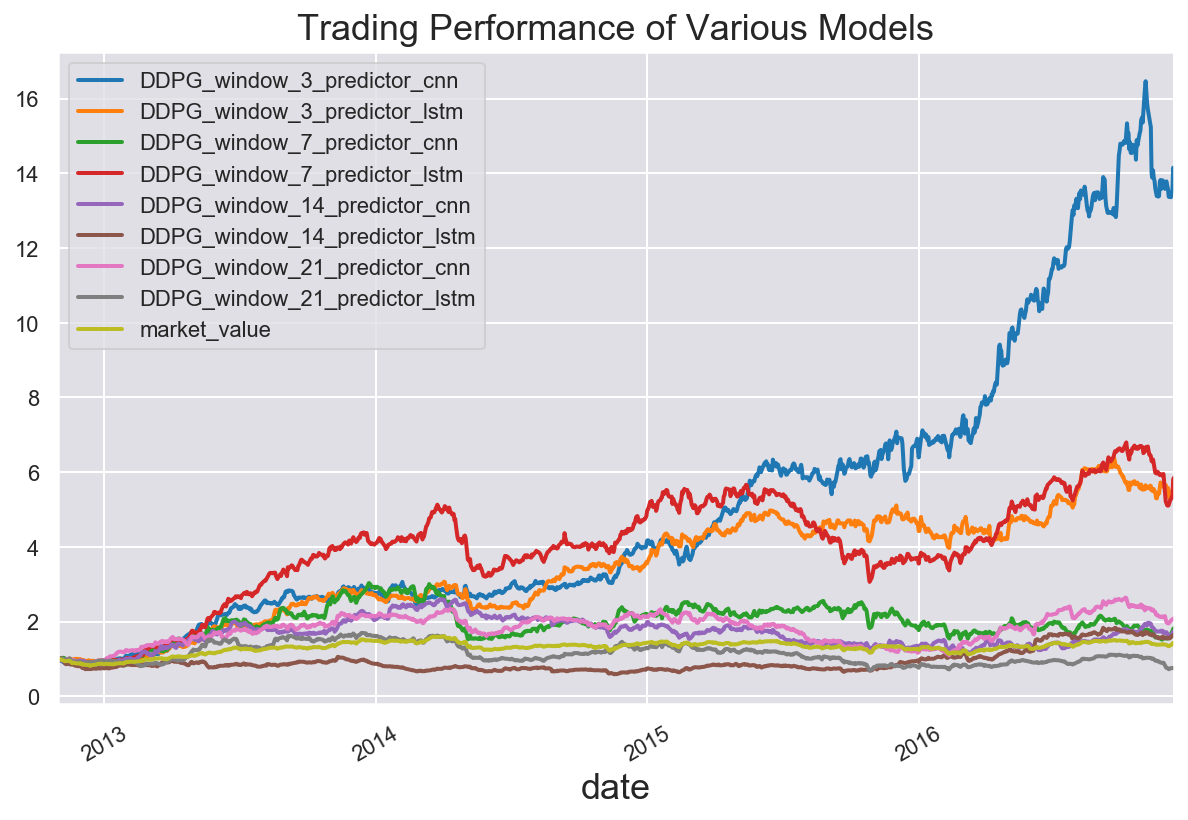

In [26]:
# evaluate the model with unseen data from same stock, fixed the starting date
env = MultiActionPortfolioEnv(testing_history, testing_stocks, model_names[8:], steps=650, start_idx=num_training_time, 
                   sample_start_date='2015-10-30')

<Figure size 720x432 with 0 Axes>

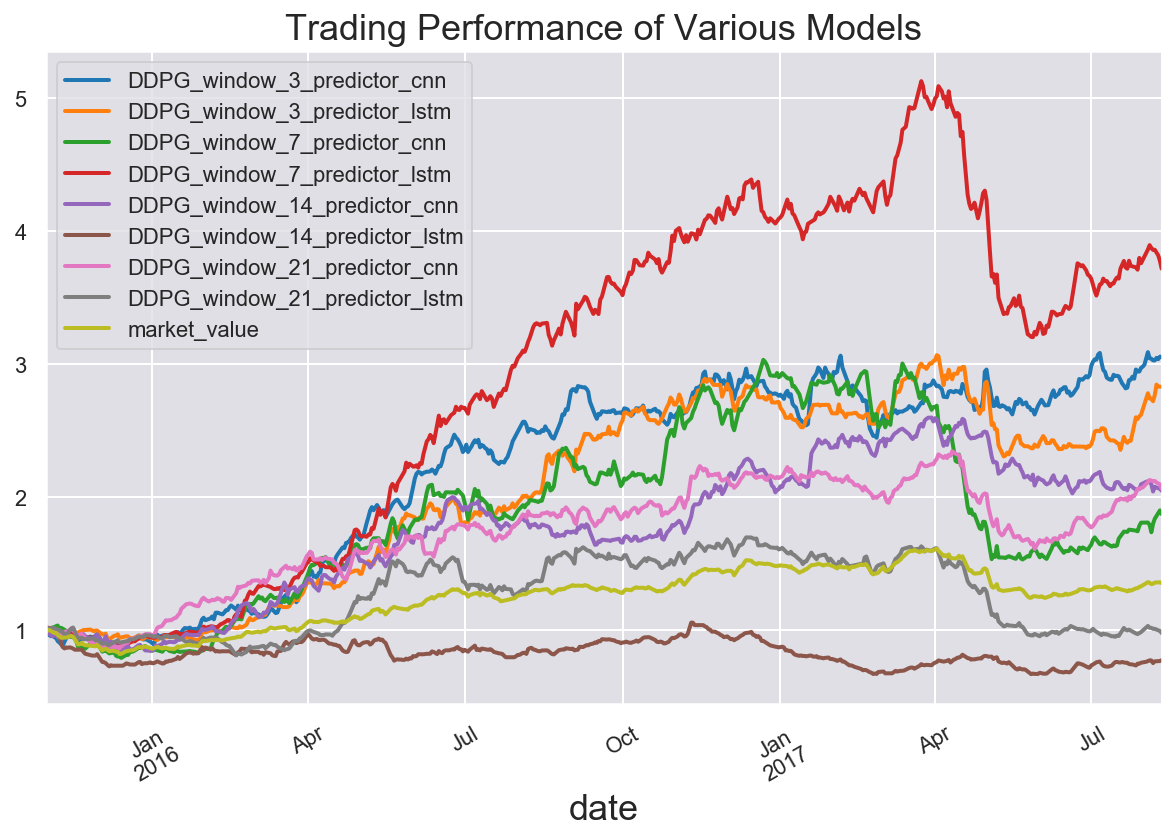

In [27]:
test_model_multiple(env, models[8:])

## Big dataset

In [37]:
from utils.data import create_dataset, write_to_h5py, create_target_dataset

In [68]:
exclude_set = {''}

In [69]:
filepath = '/Users/zachariemartin/Desktop/School/Projects/summer2019/sum19/all_stocks_5yr.csv'
create_dataset(filepath)

OSError: Unable to create file (unable to open file: name = 'datasets/stocks_history_2.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 602)

In [48]:
import csv
import datetime
import numpy as np
import h5py

start_date = '2012-08-13'
end_date = '2017-08-11'
date_format = '%Y-%m-%d'
start_datetime = datetime.datetime.strptime(start_date, date_format)
end_datetime = datetime.datetime.strptime(end_date, date_format)
number_datetime = (end_datetime - start_datetime).days + 1

exclude_set = {''}

In [65]:
exclude_set = {''}

In [66]:
type(exclude_set)

set

In [67]:
history = np.empty(shape=(460, number_datetime, 5), dtype=np.float)
abbreviation = []
with open(filepath, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    first_row = next(reader)
    current_company = None
    current_company_index = -1
    current_date = None
    current_date_index = None
    previous_day_data = None
    for row in reader:
        if row[6] in exclude_set:
            continue
        if row[6] != current_company:
            current_company_index += 1
            # initialize
            if current_date != None and (current_date - end_datetime).days != 1:
                print(row[6])
                print(current_date)
            assert current_date is None or (current_date - end_datetime).days == 1, \
                'Previous end date is not 2017-08-11'
            current_date = start_datetime
            current_date_index = 0
            date = datetime.datetime.strptime(row[0], date_format)
            if (date - start_datetime).days != 0:
                print(row[6])
                print(current_date)
                exclude_set.add(row[6])
                current_date = end_datetime + datetime.timedelta(days=1)
                continue
            assert (date - start_datetime).days == 0, 'Start date is not 2012-08-13'
            try:
                if row[5] == '':
                    row[5] = 0
                data = np.array(list(map(float, row[1:6])))
            except:
                print(row[6])
                assert False
            history[current_company_index][current_date_index] = data
            previous_day_data = data

            current_company = row[6]
            abbreviation.append(current_company)
        else:
            date = datetime.datetime.strptime(row[0], date_format)
            # missing date, loop to the date difference is 0
            while (date - current_date).days != 0:
                history[current_company_index][current_date_index] = previous_day_data.copy()
                current_date += datetime.timedelta(days=1)
                current_date_index += 1
            # miss data
            try:
                data = np.array(list(map(float, row[1:6])))
            except:
                data = previous_day_data.copy()
            history[current_company_index][current_date_index] = data
            previous_day_data = data

        current_date += datetime.timedelta(days=1)
        current_date_index += 1

ABBV
2012-08-13 00:00:00
ALLE
2012-08-13 00:00:00
AGN
2012-08-13 00:00:00
AAL
2012-08-13 00:00:00
AON
2012-08-13 00:00:00
BHGE
2012-08-13 00:00:00
BHF
2012-08-13 00:00:00
AVGO
2012-08-13 00:00:00
CHTR
2012-08-13 00:00:00
CFG
2012-08-13 00:00:00
COTY
2012-08-13 00:00:00
CCI
2012-08-13 00:00:00
CSRA
2012-08-13 00:00:00
DXC
2012-08-13 00:00:00
ETN
2012-08-13 00:00:00
EVHC
2012-08-13 00:00:00
EQIX
2012-08-13 00:00:00
FTV
2012-08-13 00:00:00
HPE
2012-08-13 00:00:00
HLT
2012-08-13 00:00:00
INFO
2012-08-13 00:00:00
ICE
2012-08-13 00:00:00
IRM
2012-08-13 00:00:00
JCI
2012-08-13 00:00:00


KeyboardInterrupt: 

In [58]:
np.array(list(map(float, row[1:6])))

array([9.229000e+01, 9.259000e+01, 9.174000e+01, 9.240000e+01,
       2.075391e+06])

## Create MGARCH dataset

In [ ]:
# create dataset